Connected to Python 3.13.1

In [6]:
import sys
sys.path.append("../Exercise_1")
sys.path.append("../Exercise_2")

import ipynb
from ipynb.fs.full.Exercise_1_solution import derivative, generate_mass_matrix, generate_stiffness_matrix
from ipynb.fs.full.Exercise_2_solution import delete_degrees_of_freedom_from_matrix, rotation_matrix_2d, reorder_matrix, assemble_global_matrix
from scipy.linalg import block_diag

import numpy as np

## Task 1 - Combine a Bar and a Beam

**Example 1:**


```python
length = 2
linear_density = 10 # rho*A
axial_stiffness = 1000 # E*A/L
transverse_stiffness = 1 # E*I/L

def bar_shape_functions(longitudinal_coordinate):
    xi = longitudinal_coordinate/length
    f1 = 1 - xi
    f2 = xi
    return np.array([f1, f2])

def beam_shape_functions(longitudinal_coordinate):
    xi = longitudinal_coordinate/length
    f1 = 1 - 3*xi**2 + 2*xi**3
    f2 = length * xi * (1-xi)**2
    f3 = xi**2 * (3-2*xi)
    f4 = length * xi**2 * (xi-1)
    return np.array([f1, f2, f3, f4])

def derivative_beam_shape_functions_num(longitudinal_coordinate):
    # or you can write the first derivatives yourself by hand
    return derivative(beam_shape_functions, longitudinal_coordinate, 1e-5)

# bar matrices
print(generate_mass_matrix(bar_shape_functions, length, linear_density, 1e-5), '\n')
print(generate_stiffness_matrix(bar_shape_functions, length, axial_stiffness, 1e-5, 1e-5), '\n')

# beam matrices
print(generate_mass_matrix(beam_shape_functions, length, linear_density, 1e-5), '\n')
print(generate_stiffness_matrix(derivative_beam_shape_functions_num, length, transverse_stiffness, 1e-5, 1e-5))
```

*Output:*

```python
[[6.66666667 3.33333333]
 [3.33333333 6.66666667]] 

[[ 1000. -1000.]
 [-1000.  1000.]] 

[[ 7.42857146  2.09523812  2.57142854 -1.23809521]
 [ 2.09523812  0.76190479  1.23809521 -0.57142854]
 [ 2.57142854  1.23809521  7.42857146 -2.09523812]
 [-1.23809521 -0.57142854 -2.09523812  0.76190479]] 

[[ 3.  3. -3.  3.]
 [ 3.  4. -3.  2.]
 [-3. -3.  3. -3.]
 [ 3.  2. -3.  4.]]
```
---

## Task 2 - Class for Beam+Bar elements

Develop the class

```python
class BarBeamElement(object):
    def __init__(self,
                coordinates_first_end: tuple[float, float], # (x1, y1)
                coordinates_second_end: tuple[float, float], # (x2, y2)
                linear_density: float, # rho*A
                axial_stiffness: float, # E*A/L
                transverse_stiffness: float): #E*I/L
        
        """
        The degrees of freedom are the displacements of the nodes in the global frame of reference
        The order of the degrees of freedom is
        x_I, y_I, theta_I, x_II, y_II, theta_II
        where I refers to the first end and II to the second end
        the x and y are the horizontal and vertical displacements in the global frame of reference
        """
        pass
    
    def generate_structural_mass_matrix(self):
        """
        Outputs the 6x6 mass matrix of the Bar+Beam element.
        """
        pass
        
    def generate_structural_stiffness_matrix(self):
        """
        Outputs the 6x6 stiffness matrix of the Bar+Beam element.
        """
        pass
```

**Example 2:**


```python
element: BarBeamElement = BarBeamElement(
    coordinates_first_end=(0,0), 
    coordinates_second_end=(2,0), 
    linear_density=10, # rho*A
    axial_stiffness=1000, # E*A/L
    transverse_stiffness=1 # E*I/L
)

print(element.generate_structural_mass_matrix(), '\n')
print(element.generate_structural_stiffness_matrix())
```

*Output:*

```python
[[ 6.66666667  0.          0.          3.33333333  0.          0.        ]
 [ 0.          7.42857146  2.09523812  0.          2.57142854 -1.23809521]
 [ 0.          2.09523812  0.76190479  0.          1.23809521 -0.57142854]
 [ 3.33333333  0.          0.          6.66666667  0.          0.        ]
 [ 0.          2.57142854  1.23809521  0.          7.42857146 -2.09523812]
 [ 0.         -1.23809521 -0.57142854  0.         -2.09523812  0.76190479]] 

[[ 1000.     0.     0. -1000.     0.     0.]
 [    0.     3.     3.     0.    -3.     3.]
 [    0.     3.     4.     0.    -3.     2.]
 [-1000.     0.     0.  1000.     0.     0.]
 [    0.    -3.    -3.     0.     3.    -3.]
 [    0.     3.     2.     0.    -3.     4.]]
```

---
## Task 3 - Assemble multiple elements

Consider the truss structure in the following figure.

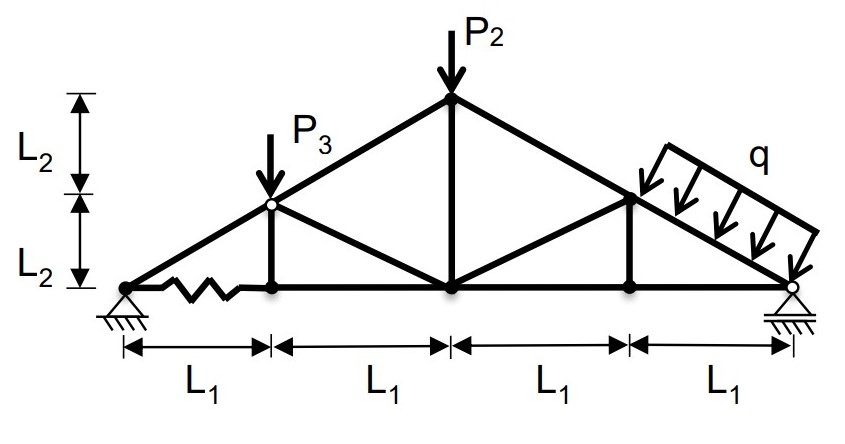

- node 1 and 2 are connected via a spring characterized by its spring-stiffness parameter
- the lengths $L_1$ and $L_2$ are parameters
- each truss member has independent parameters for the mass, Young's modulus, cross-sectional area and moment of area
- the "open circle 🔘" nodes do not constrain the relative angle of the attached truss members
- the "full circle ⚫" nodes fix the relative angle of the attached truss members

---

The structure is discretized into Bar+Beam as follows

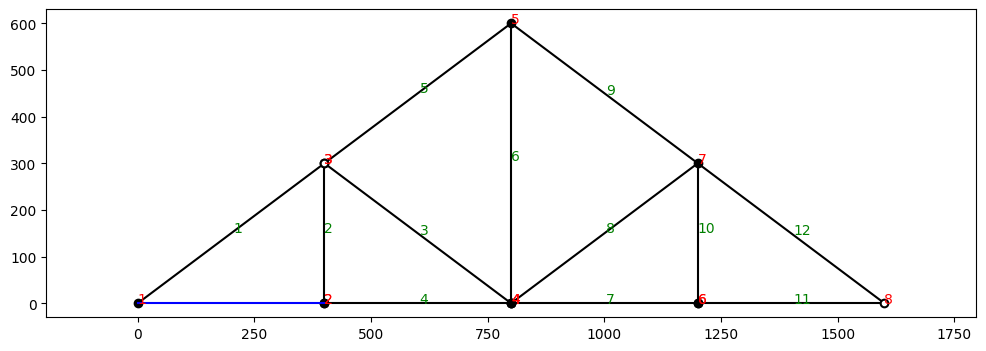

- the blue line represents the spring
- the black lines represent the Bar+Beam elements, numbered in green
- the nodes are numbered in red

Consider the following global ordering and boundary conditions:

---
**Bar + Beam 1**:
- First end at node 1:
	* $x_{I}=q_{0}$,
	* $y_{I}=q_{1}$,
	* $\theta_{I}=q_{2}$,
- Second end at node 3:
	* $x_{II}=q_{6}$,
	* $y_{II}=q_{7}$,
	* $\theta_{II}=q_{8}$ 

---
**Bar + Beam 2**:
- First end at node 2:
	* $x_{I}=q_{3}$,
	* $y_{I}=q_{4}$,
	* $\theta_{I}=q_{5}$,
- Second end at node 3:
	* $x_{II}=q_{6}$,
	* $y_{II}=q_{7}$,
	* $\theta_{II}=q_{24}$ 

---
**Bar + Beam 3**:
- First end at node 3:
	* $x_{I}=q_{6}$,
	* $y_{I}=q_{7}$,
	* $\theta_{I}=q_{25}$,
- Second end at node 4:
	* $x_{II}=q_{9}$,
	* $y_{II}=q_{10}$,
	* $\theta_{II}=q_{11}$ 

---
**Bar + Beam 4**:
- First end at node 2:
	* $x_{I}=q_{3}$,
	* $y_{I}=q_{4}$,
	* $\theta_{I}=q_{5}$,
- Second end at node 4:
	* $x_{II}=q_{9}$,
	* $y_{II}=q_{10}$,
	* $\theta_{II}=q_{11}$ 

---
**Bar + Beam 5**:
- First end at node 3:
	* $x_{I}=q_{6}$,
	* $y_{I}=q_{7}$,
	* $\theta_{I}=q_{26}$,
- Second end at node 5:
	* $x_{II}=q_{12}$,
	* $y_{II}=q_{13}$,
	* $\theta_{II}=q_{14}$ 

---
**Bar + Beam 6**:
- First end at node 4:
	* $x_{I}=q_{9}$,
	* $y_{I}=q_{10}$,
	* $\theta_{I}=q_{11}$,
- Second end at node 5:
	* $x_{II}=q_{12}$,
	* $y_{II}=q_{13}$,
	* $\theta_{II}=q_{14}$ 

---
**Bar + Beam 7**:
- First end at node 4:
	* $x_{I}=q_{9}$,
	* $y_{I}=q_{10}$,
	* $\theta_{I}=q_{11}$,
- Second end at node 6:
	* $x_{II}=q_{15}$,
	* $y_{II}=q_{16}$,
	* $\theta_{II}=q_{17}$ 

---
**Bar + Beam 8**:
- First end at node 4:
	* $x_{I}=q_{9}$,
	* $y_{I}=q_{10}$,
	* $\theta_{I}=q_{11}$,
- Second end at node 7:
	* $x_{II}=q_{18}$,
	* $y_{II}=q_{19}$,
	* $\theta_{II}=q_{20}$ 

---
**Bar + Beam 9**:
- First end at node 5:
	* $x_{I}=q_{12}$,
	* $y_{I}=q_{13}$,
	* $\theta_{I}=q_{14}$,
- Second end at node 7:
	* $x_{II}=q_{18}$,
	* $y_{II}=q_{19}$,
	* $\theta_{II}=q_{20}$ 

---
**Bar + Beam 10**:
- First end at node 6:
	* $x_{I}=q_{15}$,
	* $y_{I}=q_{16}$,
	* $\theta_{I}=q_{17}$,
- Second end at node 7:
	* $x_{II}=q_{18}$,
	* $y_{II}=q_{19}$,
	* $\theta_{II}=q_{20}$ 

---
**Bar + Beam 11**:
- First end at node 6:
	* $x_{I}=q_{15}$,
	* $y_{I}=q_{16}$,
	* $\theta_{I}=q_{17}$,
- Second end at node 8:
	* $x_{II}=q_{21}$,
	* $y_{II}=q_{22}$,
	* $\theta_{II}=q_{23}$ 

---
**Bar + Beam 12**:
- First end at node 7:
	* $x_{I}=q_{18}$,
	* $y_{I}=q_{19}$,
	* $\theta_{I}=q_{20}$,
- Second end at node 8:
	* $x_{II}=q_{21}$,
	* $y_{II}=q_{22}$,
	* $\theta_{II}=q_{27}$

---
**Spring**
- First end at node 1:
    * $x_{I} = q_0$ 
- Second end at node 2:
    * $x_{II} = q_3$ 

---
**Boundary conditions**

At node 1:
- $x = q_0 = 0$
- $y = q_1 = 0$

At node 8
- $y = q_{22} = 0$
---

**Example 3**

Consider the data

```python
area_cross_section = 10
length1 = 400
length2 = 300
moment_of_area = 100
Youngs_modulus = 100000
spring_stiffness = 10000
linear_density = 1e-3
```

The stiffness and mass matrices (rounded to two decimal place to fit on screen) are

```python
Stiffness Matrix:
[80000, 0, 0, 0, 144, -192, 40000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 12504.44, 0, -666.67, -4.44, -0, 0, -2500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -666.67, 0, 0, 0]
[0, 0, 3335.21, 375, -0, -3333.33, 0, 0, -1.87, 375, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, -666.67, 375, 233333.33, 666.67, -0, 0, 0, -375, 50000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 66666.67, 0, 0, 0]
[144, -4.44, -0, 666.67, 3845.48, 959.54, 144, -1280.35, 959.54, 144, -1280.35, -959.54, -144, 0, 0, 0, 0, 0, 0, 0, 0, 666.67, 144, -144, 0]
[-192, -0, -3333.33, -0, 959.54, 5495.18, -192, 959.54, -720.61, 192, -959.54, -720.61, 192, 0, 0, 0, 0, 0, 0, 0, 0, -0, 192, 192, 0]
[40000, 0, 0, 0, 144, -192, 80000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, -2500, 0, 0, -1280.35, 959.54, 0, 7561.25, -0, -454.67, -0.56, -0, -166.67, -2500, 0, 0, -1280.35, -959.54, -144, 0, 0, 0, -144, 0, 0]
[0, 0, -1.87, -375, 959.54, -720.61, 0, -0, 3111.65, 0, -0, -1666.67, 0, 0, -1.87, 375, -959.54, -720.61, 192, 0, 0, 0, -192, 0, 0]
[0, 0, 375, 50000, 144, 192, 0, -454.67, 0, 426666.67, 166.67, -0, 33333.33, 0, -375, 50000, 144, -192, 40000, 0, 0, 0, 40000, 0, 0]
[0, 0, 0, 0, -1280.35, -959.54, 0, -0.56, -0, 166.67, 2561.25, 0, 454.67, 0, 0, 0, -1280.35, 959.54, 144, 0, 0, 0, 0, 144, 0]
[0, 0, 0, 0, -959.54, -720.61, 0, -0, -1666.67, -0, 0, 3107.9, 0, 0, 0, 0, 959.54, -720.61, 192, 0, 0, 0, 0, -192, 0]
[0, 0, 0, 0, -144, 192, 0, -166.67, 0, 33333.33, 454.67, 0, 226666.67, 0, 0, 0, -144, -192, 40000, 0, 0, 0, 0, 40000, 0]
[0, 0, 0, 0, 0, 0, 0, -2500, 0, 0, 0, 0, 0, 5004.44, 0, -666.67, -4.44, -0, -666.67, -2500, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, -1.87, -375, 0, 0, 0, 0, 3337.08, 0, -0, -3333.33, 0, 0, 375, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 375, 50000, 0, 0, 0, -666.67, 0, 333333.33, 666.67, -0, 66666.67, 0, 50000, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, -1280.35, -959.54, 144, -1280.35, 959.54, -144, -4.44, -0, 666.67, 3845.48, -959.54, 810.67, -1280.35, 0, 0, 0, 0, 144]
[0, 0, 0, 0, 0, 0, 0, -959.54, -720.61, -192, 959.54, -720.61, -192, -0, -3333.33, -0, -959.54, 5495.18, -192, 959.54, 0, 0, 0, 0, 192]
[0, 0, 0, 0, 0, 0, 0, -144, 192, 40000, 144, 192, 40000, -666.67, 0, 66666.67, 810.67, -192, 373333.33, -144, 0, 0, 0, 0, 40000]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2500, 0, 0, -1280.35, 959.54, -144, 3780.35, 0, 0, 0, 0, -144]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 375, 50000, 0, 0, 0, 0, 100000, 0, 0, 0, 0]
[0, -666.67, 0, 66666.67, 666.67, -0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133333.33, 0, 0, 0]
[0, 0, 0, 0, 144, 192, 0, -144, -192, 40000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80000, 0, 0]
[0, 0, 0, 0, -144, 192, 0, 0, 0, 0, 144, -192, 40000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80000, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 144, 192, 40000, -144, 0, 0, 0, 0, 80000]

Mass Matrix:
[1190.48, 0, 0, 0, -4.64, 6.19, -892.86, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0.24, -0, -4.71, 0.04, 0, 0, 0.07, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.79, 0, 0, 0]
[0, -0, 0.25, 8.38, 0, 0.05, 0, 0, 0.05, -4.95, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0, 0, 0, 0]
[0, -4.71, 8.38, 866.67, -2.79, 0, 0, 0, 4.95, -457.14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -192.86, 0, 0, 0]
[-4.64, 0.04, 0, -2.79, 0.63, -0.01, 7.86, 0.08, -0.01, -4.64, 0.08, 0.01, 4.64, 0, 0, 0, 0, 0, 0, 0, 0, 4.71, 7.86, -7.86, 0]
[6.19, 0, 0.05, 0, -0.01, 0.64, -10.48, -0.01, 0.07, -6.19, 0.01, 0.07, -6.19, 0, 0, 0, 0, 0, 0, 0, 0, -0, 10.48, 10.48, 0]
[-892.86, 0, 0, 0, 7.86, -10.48, 1190.48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0.07, 0, 0, 0.08, -0.01, 0, 0.84, 0, -34.57, 0.08, 0, 11.14, 0.07, 0, 0, 0.08, 0.01, 4.64, 0, 0, 0, 4.64, 0, 0]
[0, 0, 0.05, 4.95, -0.01, 0.07, 0, -0, 0.85, -0, 0, 0.1, -0, 0, 0.05, -4.95, 0.01, 0.07, -6.19, 0, 0, 0, 6.19, 0, 0]
[0, 0, -4.95, -457.14, -4.64, -6.19, 0, -34.57, -0, 5657.14, -11.14, 0, -1542.86, 0, 4.95, -457.14, -4.64, 6.19, -892.86, 0, 0, 0, -892.86, 0, 0]
[0, 0, 0, 0, 0.08, 0.01, 0, 0.08, 0, -11.14, 0.57, -0, 34.57, 0, 0, 0, 0.08, -0.01, -4.64, 0, 0, 0, 0, -4.64, 0]
[0, 0, 0, 0, 0.01, 0.07, 0, 0, 0.1, 0, -0, 0.56, -0, 0, 0, 0, -0.01, 0.07, -6.19, 0, 0, 0, 0, 6.19, 0]
[0, 0, 0, 0, 4.64, -6.19, 0, 11.14, -0, -1542.86, 34.57, -0, 4438.1, 0, 0, 0, 4.64, 6.19, -892.86, 0, 0, 0, 0, -892.86, 0]
[0, 0, 0, 0, 0, 0, 0, 0.07, 0, 0, 0, 0, 0, 0.38, -0, -4.71, 0.04, 0, 2.79, 0.07, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0.05, 4.95, 0, 0, 0, -0, 0.4, -0, 0, 0.05, -0, 0, -4.95, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, -4.95, -457.14, 0, 0, 0, -4.71, -0, 1476.19, -2.79, 0, -192.86, 0, -457.14, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0.08, 0.01, -4.64, 0.08, -0.01, 4.64, 0.04, 0, -2.79, 0.63, 0.01, 12.57, 0.08, 0, 0, 0, 0, -4.64]
[0, 0, 0, 0, 0, 0, 0, 0.01, 0.07, 6.19, -0.01, 0.07, 6.19, 0, 0.05, 0, 0.01, 0.64, -10.48, -0.01, 0, 0, 0, 0, -6.19]
[0, 0, 0, 0, 0, 0, 0, 4.64, -6.19, -892.86, -4.64, -6.19, -892.86, 2.79, -0, -192.86, 12.57, -10.48, 3828.57, 4.64, 0, 0, 0, 0, -892.86]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07, 0, 0, 0.08, -0.01, 4.64, 0.31, 0, 0, 0, 0, -7.86]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -4.95, -457.14, 0, 0, 0, 0, 609.52, 0, 0, 0, 0]
[0, 2.79, -0, -192.86, 4.71, -0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 257.14, 0, 0, 0]
[0, 0, 0, 0, 7.86, 10.48, 0, 4.64, 6.19, -892.86, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1190.48, 0, 0]
[0, 0, 0, 0, -7.86, 10.48, 0, 0, 0, 0, -4.64, 6.19, -892.86, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1190.48, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -4.64, -6.19, -892.86, -7.86, 0, 0, 0, 0, 1190.48]
 ```